In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import numpy as np
import igraph as ig
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt

from split_utils import read_fasta, Identity, compute_identity_stats

In [3]:
THRESHOLD = 0.5
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Load data

In [15]:
dm = np.load(f".cache/identity_matrix.npy")
with open(f".cache/row_ids.txt", 'r') as f:
    dm_ids = np.array([int(id_) for id_ in f.readlines()])

dataset = read_fasta("../data/build/dataset.fasta")
dataset = {int(id_): seq for id_, seq in dataset}

# Filter like for the other experiments
mask = np.array([MIN_SEQ_LEN <= len(dataset[id_]) <= MAX_SEQ_LEN for id_ in dm_ids])
dm = dm[mask][:, mask]  # Filter the distance matrix
dm_ids = dm_ids[mask]  # Filter the IDs accordingly

# Create graph

In [41]:
adjacency_matrix = (dm > THRESHOLD).astype(int)

# Make edge list from adjacency matrix
edge_list = []
for i in range(adjacency_matrix.shape[0]):
    for j in range(i + 1, adjacency_matrix.shape[1]):  # only upper triangle for undirected
        if adjacency_matrix[i, j] == 1:
            edge_list.append((i, j))
nodeidx2id = {i: dm_ids[i] for i in range(len(dm_ids))}
if not os.path.exists(".cache/communities"):
    os.makedirs(".cache/communities")

# Create edgelist file
with open(".cache/communities/graph.edgelist", 'w') as f:
    for i, j in edge_list:
        f.write(f"{i}\t{j}\n")

# Load graph
g = ig.Graph.Read_Edgelist(".cache/communities/graph.edgelist", directed=False)

# Find communities using Leiden algorithm

In [43]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

clusters = g.connected_components()  # or g.connected_components()
# Map each node to its component ID
nodeidx2component = {}
for comp_id, component in enumerate(clusters):
    for node_idx in component:
        nodeidx2component[node_idx] = comp_id

# Now, make dataframe with communities
df = {"node_id": [], "community": [], "component": []}
for i, comm in enumerate(partition):
    for node in comm:
        df["node_id"].append(nodeidx2id[node])
        df["community"].append(i)
        df["component"].append(nodeidx2component[node])

df = pd.DataFrame(df)

|# Split clusters into two sets

In [44]:
# Now split the dataset into communities
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['community'].unique()
    print(f"Found {len(cluster_ids)} clusters in the dataset.")
    # Clusters are ordered by size, so we can just take the last n_test clusters in order to maximize the diversity
    # Compute the cumsum of the cluster sizes
    cluster_ids = clusters['community'].unique()
    np.random.shuffle(cluster_ids)
    cluster_ids = cluster_ids.tolist()
    test_ids = []
    test_max = int(len(clusters) * test_ratio)
    while len(test_ids) < test_max:
        cluster = cluster_ids.pop()
        test_ids.extend(clusters[clusters['community'] == cluster]['node_id'].tolist())
    train_ids = clusters[~clusters['node_id'].isin(test_ids)]['node_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(df)

Found 1551 clusters in the dataset.


# Assert independence between training and test sets

In [45]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  3587/3587 [09:01<00:00, 6.37it/s] 


In [46]:
test2train_id = identities.max(axis=1)

Max identity: 0.9444444444444444
Mean identity: 0.49898864624816164
Median identity: 0.47619047619047616
Quantiles:
- 0.01 quantile: 0.34782608695652173
- 0.05 quantile: 0.38461538461538464
- 0.10 quantile: 0.4074074074074074
- 0.25 quantile: 0.44
- 0.50 quantile: 0.47619047619047616
- 0.75 quantile: 0.5333333333333333
- 0.90 quantile: 0.625
- 0.95 quantile: 0.7
- 0.99 quantile: 0.8888888888888888
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
12037


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

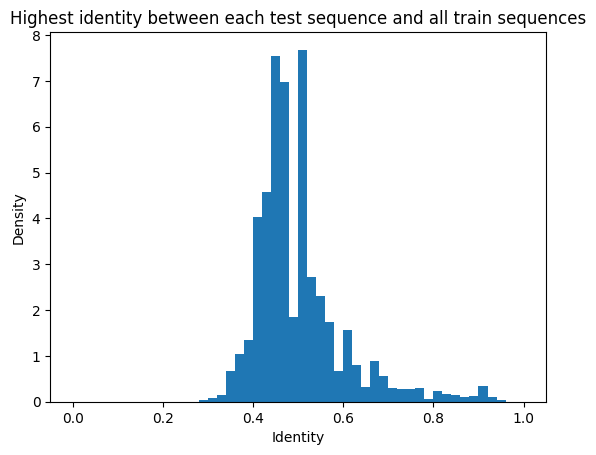

In [47]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

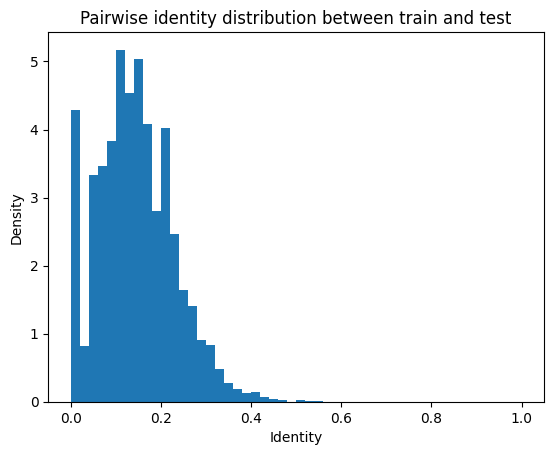

In [11]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 14269


In [50]:
com1 = df.loc[df['community'] == 0, 'node_id'].tolist()
com2 = df.loc[df['community'] == 1, 'node_id'].tolist()
len(com1), len(com2)

(1589, 1423)

In [51]:
iden = np.empty((len(com1), len(com2)))
for i, id1 in enumerate(com1):
    for j, id2 in enumerate(com2):
        identity = identity_calculator.align_by_id(id1, id2)
        iden[i, j] = identity
        if identity > 0.5:
            print(f"{id1}\t{id2}\t{identity:.2f}")


print((iden > 0.5).sum())


375	399	0.55
375	5443	0.55
408	3468	0.53
408	20148	0.53
408	23699	0.53
717	19900	0.54
1103	9634	0.57
1750	944	0.54
1750	946	0.54
2708	3249	0.57
4777	10283	0.54
7052	3253	0.56
7052	10180	0.54
7052	11548	0.56
7052	17239	0.56
7064	944	0.54
7064	946	0.54
7070	2860	0.56
7070	2861	0.55
7070	2864	0.55
7070	2872	0.64
7070	2873	0.58
7070	3249	0.56
7070	20143	0.60
8101	20155	0.56
9534	2873	0.53
9534	2874	0.53
9534	13691	0.53
9534	14069	0.60
9630	9634	0.71
9631	9634	0.57
9632	9634	0.57
9633	9634	0.71
9633	11548	0.57
9633	17257	0.56
9633	17258	0.56
9633	17259	0.56
9633	17260	0.56
9633	17261	0.56
9633	17262	0.56
9633	18614	0.62
9633	22574	0.55
9633	22575	0.55
9820	2857	0.56
9820	23131	0.56
9997	9994	0.75
9998	9994	0.62
9999	9994	0.88
10627	11412	0.53
11549	6770	0.55
11549	11548	0.57
11620	2858	0.56
11620	2875	0.55
11620	20150	0.56
11622	2858	0.56
11622	2875	0.55
11622	20150	0.56
11623	2858	0.56
11623	2875	0.55
11623	20150	0.56
11624	2858	0.56
11624	2875	0.55
11624	20150	0.56
11645	2857	0.56
11645	2